In [165]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

from geogif import gif   # To create the GIF
from IPython.display import Image  # To nicely display images
import matplotlib.pyplot as plt


In [23]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


catalog.get_collections()
collections = list(catalog.get_collections()) # Turn generator into list

# Print the number of collections
print('Number of collections:', len(collections))

# Pull out the NAIP collection
biodiversity = catalog.get_child('io-biodiversity')
biodiversity


Number of collections: 126


<CollectionClient id=io-biodiversity>

In [24]:
# Temporal range of interest during drought
time_range = "2017-01-01/2020-01-01"

In [25]:
# bounding box 
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

In [26]:
# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'], 
    bbox = bbox, 
    datetime = time_range)


# Get items from search
search

# Determine number of items in search
items = search.item_collection()
len(items)


4

In [27]:
items

In [28]:
# Get first item in the catalog search
item1 = items[0]
item1

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>

In [40]:
# Get first item in the catalog search
item3 = items[3]
item3

<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>

In [31]:
item1.assets

{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2020/bii_2020_34.74464974521749_-115.38597824385106_cog.tif?st=2025-12-05T01%3A59%3A08Z&se=2025-12-06T02%3A44%3A08Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-12-04T10%3A59%3A31Z&ske=2025-12-11T10%3A59%3A31Z&sks=b&skv=2025-07-05&sig=ScspYaR4uaemBzwfy6%2Bcjkgs/O8FnghC3A/6Y8KNB3k%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.

In [44]:
raster2020 = rioxr.open_rasterio(item1.assets['data'].href) 
raster2020

raster2017 = rioxr.open_rasterio(item3.assets['data'].href) 
raster2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [35]:
arizona = gpd.read_file(os.path.join('data', 'tl_2023_AZ', 'tl_2023_04_cousub.shp'))

In [58]:
phoenix = arizona[arizona['NAME'] == 'Phoenix']
phoenix

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
10,04,013,92601,01934968,0401392601,0600000US0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,S,2806470560,9471133,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


<Axes: >

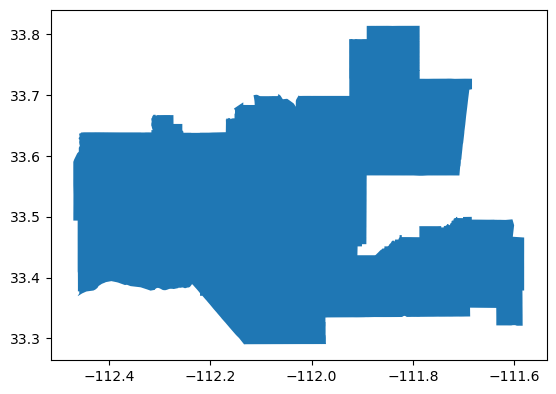

In [60]:
phoenix.plot()


In [73]:
assert raster2020.rio.crs == raster2020.rio.crs

In [ ]:
phoenix = phoenix.to_crs(raster2020.rio.crs)

In [65]:
# Makes sure crs match 
assert raster2020.rio.crs == phoenix.crs

In [ ]:
# Clip raster to bounding box
#raster1.rio.clip_box(*box_df.total_bounds)

raster2020_clip = (raster2020.rio.clip_box(*phoenix.total_bounds)
                   .rio.clip(phoenix.geometry))

raster2017_clip = (raster2017.rio.clip_box(*phoenix.total_bounds)
                   .rio.clip(phoenix.geometry))

<xarray.DataArray (band: 1, y: 583, x: 990)> Size: 2MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 5kB 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

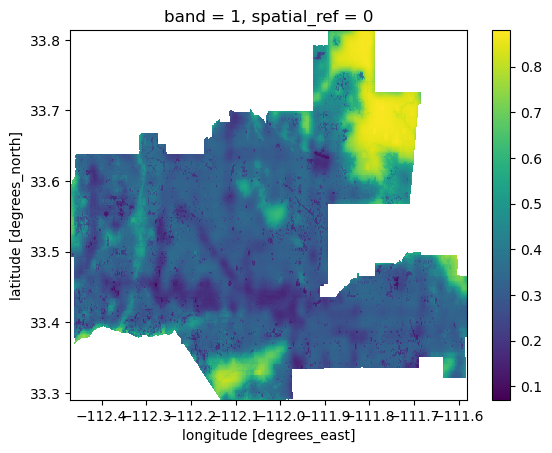

In [77]:
raster2017_clip.sel(band=1).plot.imshow()

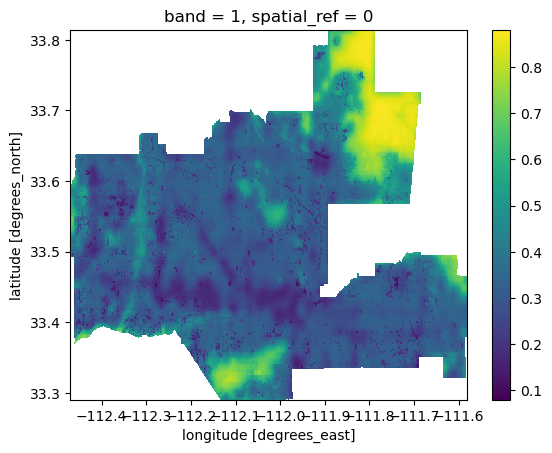

In [72]:
raster2020_clip.sel(band=1).plot.imshow()

In [ ]:
raster2017_clip.squeeze().drop_vars('band')
raster2020_clip.squeeze().drop_vars('band')


<xarray.DataArray (y: 583, x: 990)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 8kB -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 5kB 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
# Mask of Boolean Operators of 
raster2020_cal = raster2020_clip >= 0.75
raster2017_cal = raster2017_clip >= 0.75

In [128]:
# Find number of cells = TRUE 
true_2020 = np.count_nonzero(raster2020_cal)
true_2017 = np.count_nonzero(raster2017_cal)

print(true_2020)
print(true_2017)


21986
24133


In [ ]:
# Find number of cells total 
raster_count = raster2020_clip.size

#print(raster2020_cal.count())

<xarray.DataArray ()> Size: 8B
array(338694)
Coordinates:
    spatial_ref  int64 8B 0
577170


In [144]:
# Area Percent  
print(f"Area Percent of 2020: {(true_2020/raster_count) * 100}")
print(f"Area Percent of 2017: {(true_2017/raster_count) * 100}")

Area Percent of 2020: 3.8092762964118023
Area Percent of 2017: 4.181263752447286


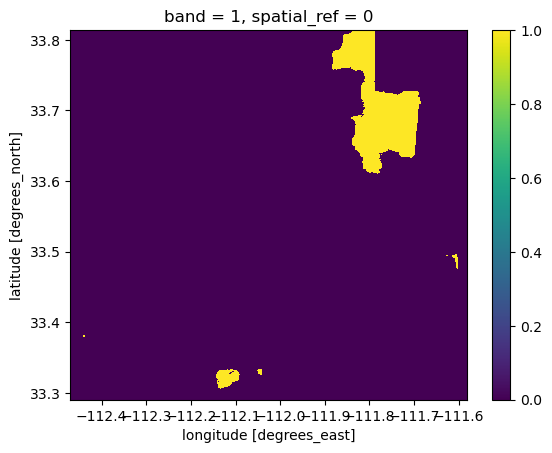

In [127]:
raster2017_cal.plot()

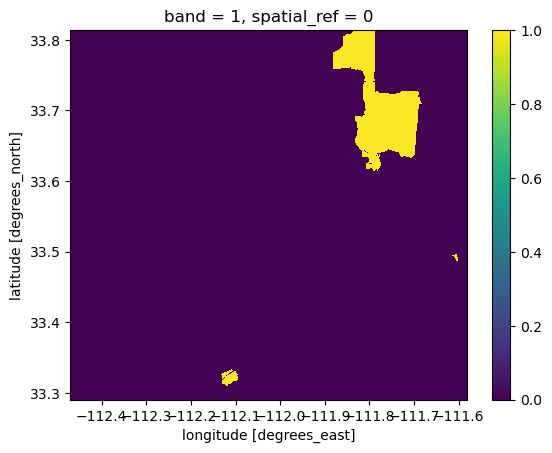

In [126]:
raster2020_cal.plot()

In [159]:
raster2020_int = raster2020_cal.astype(int)
raster2017_int = raster2017_cal.astype(int)

In [171]:
difference = raster2017_int - raster2020_int

In [ ]:
[difference > 0] == 

NameError: name 'NA' is not defined

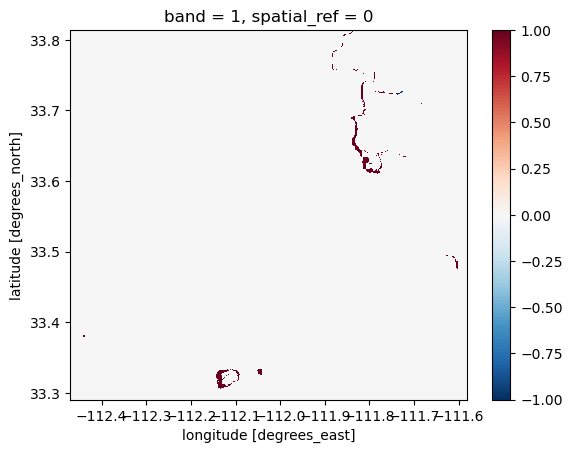

In [172]:
difference.plot()

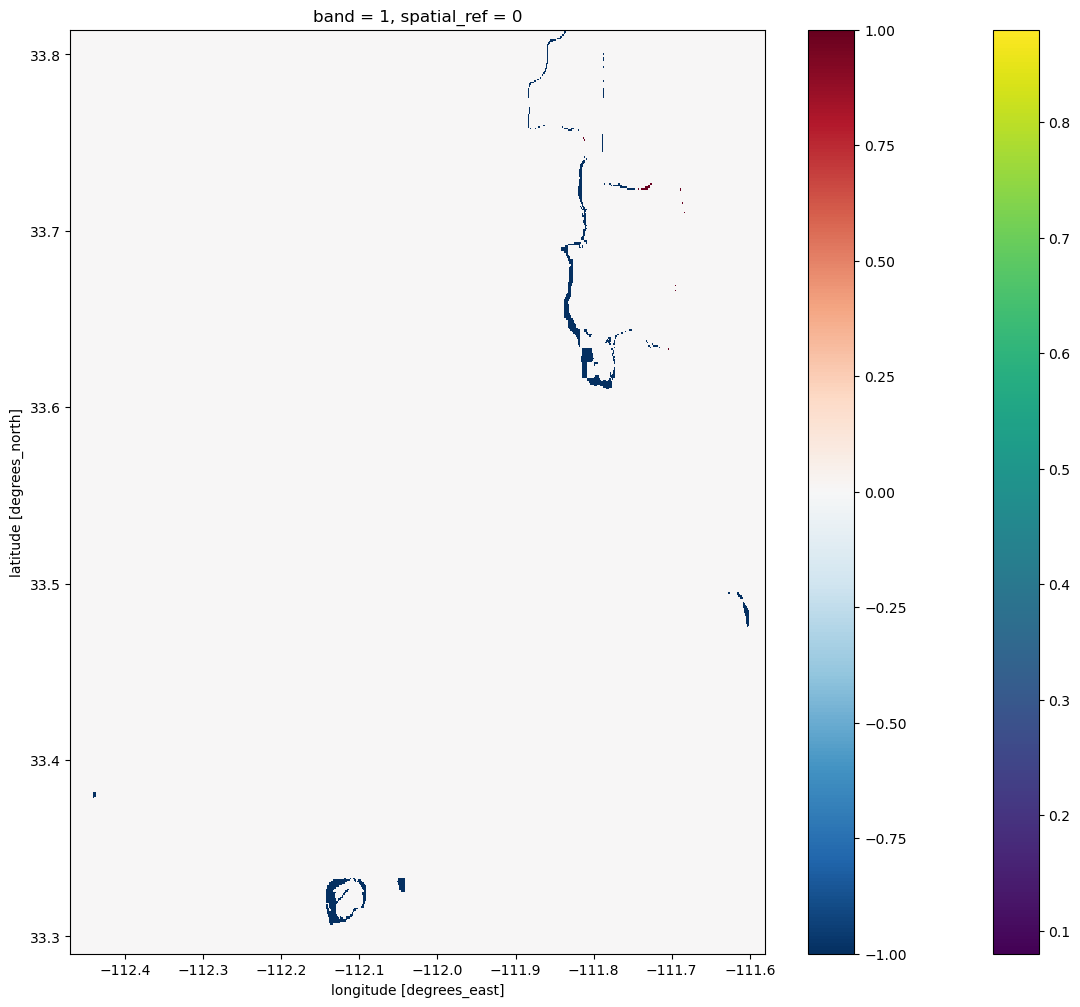

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

raster2020_clip.plot(ax = ax)
difference.plot(ax = ax)